# 1) Importing Libraries

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
#sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop, Nadam
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image


In [2]:
import os
# os.listdir('Final_Arabic_Alpha_dataset/train/')

# 2) Training dataset preparation

### 2.1) Get the training dataset

In [164]:
DIR = 'Final_Arabic_Alpha_dataset/train'
X = []
Z = []
Label_names = []
IMG_SIZE = 64
dictionary_of_labels = {}

In [165]:
def make_train_data():
    for label in tqdm(os.listdir(DIR)):
        if label == '.DS_Store' :
            continue
        label_path = os.path.join(DIR, label)
        for image_name in os.listdir(label_path): 
            image_path = os.path.join(label_path, image_name)
            result_label = image_name[8:-8]
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)
            if img is None:
                print('Wrong path:', img)
            else:
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                X.append(np.array(img))
                Z.append(int(label))
        dictionary_of_labels[int(label)] = str(result_label)

In [166]:
make_train_data()

100%|█████████████████████████████████████████████| 66/66 [00:14<00:00,  4.60it/s]


In [167]:
print(len(Z))
#42559

42559


### 2.3) Visualizing some Random Images

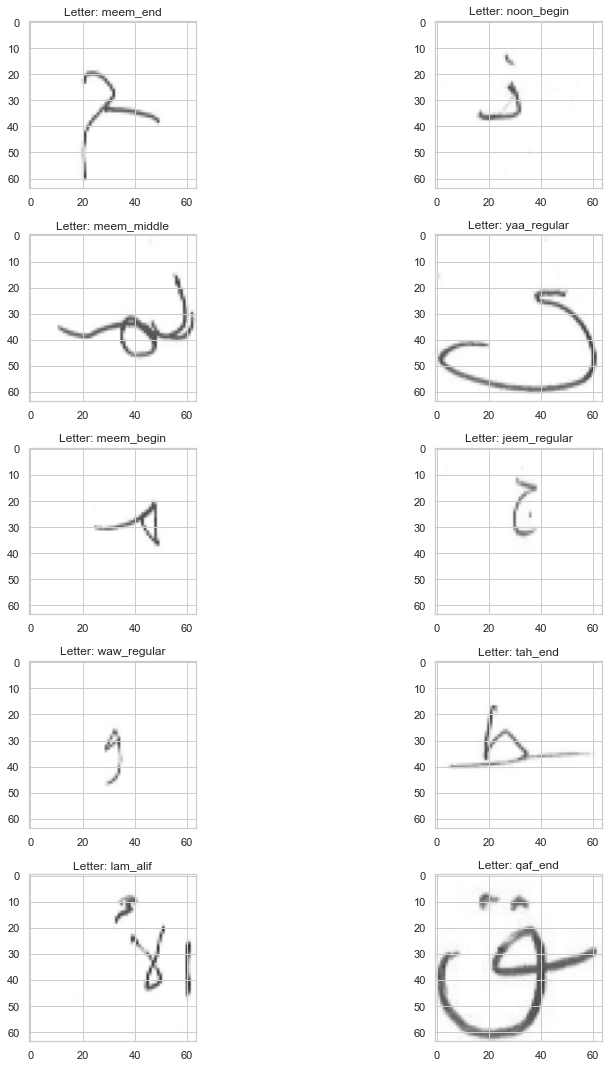

In [169]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Letter: '+ dictionary_of_labels[Z[l]])
        
plt.tight_layout()

### 2.4 ) Label Encoding the Z array (0 - 64)

In [170]:
le=LabelEncoder()
Y=le.fit_transform(Z)
X=np.array(X)
# X=X/255

In [182]:
Z = np.array(Z) 

### 2.5) Splitting into Training and Validation Sets

In [184]:
x_train,x_test,y_train,y_test=train_test_split(X,Z,test_size=0.25,random_state=42)

### 2.6) Setting the Random Seeds

In [185]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

# 3) Modeling

### 3.1) Building the ConvNet Model

In [186]:
# modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (64,64,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(65, activation = "softmax"))

### 3.2 ) Using a LR Annealer

In [187]:
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=5,verbose=1,factor=0.1)

### 3.3 ) Data Augmentation to prevent Overfitting

In [188]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

### 3.4 ) Compiling the Keras Model & Summary

In [189]:
model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# model.compile(optimizer = SGD(lr=0.1) ,loss='sparse_categorical_crossentropy', metrics=['accuracy']) 
# causing overfitting
# model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
# causing underfitting
# model.compile(optimizer=Adagrad(lr=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
# causing underfitting
# model.compile(optimizer=Nadam(lr=0.002), loss='categorical_crossentropy', metrics=['accuracy'])


In [190]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 64, 64, 32)        2432      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 16, 16, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 16, 16, 96)        55392     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 8, 8, 96)        

In [191]:
# y_train = np.expand_dims(y_train, axis=-1)
# y_test = np.expand_dims(y_test, axis=-1)
# x_test = np.expand_dims(x_test, axis=-1)

In [192]:
# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)

In [193]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=250,  callbacks=[red_lr])
# model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data = (x_test,y_test))

Epoch 1/50
250/250 [==============================] - 56s 222ms/step - loss: 4.9480 - accuracy: 0.0345 - val_loss: 3.5854 - val_accuracy: 0.1118 - lr: 0.0010
Epoch 2/50
250/250 [==============================] - 55s 219ms/step - loss: 3.3665 - accuracy: 0.1485 - val_loss: 2.3796 - val_accuracy: 0.3274 - lr: 0.0010
Epoch 3/50
250/250 [==============================] - 58s 230ms/step - loss: 2.3993 - accuracy: 0.3367 - val_loss: 1.5724 - val_accuracy: 0.5229 - lr: 0.0010
Epoch 4/50
250/250 [==============================] - 57s 228ms/step - loss: 1.7733 - accuracy: 0.4839 - val_loss: 1.1568 - val_accuracy: 0.6386 - lr: 0.0010
Epoch 5/50
250/250 [==============================] - 57s 226ms/step - loss: 1.4952 - accuracy: 0.5583 - val_loss: 0.9558 - val_accuracy: 0.7035 - lr: 0.0010
Epoch 6/50
250/250 [==============================] - 57s 227ms/step - loss: 1.3459 - accuracy: 0.5973 - val_loss: 0.8899 - val_accuracy: 0.7224 - lr: 0.0010
Epoch 7/50
250/250 [==============================] 

Epoch 47/50
250/250 [==============================] - 59s 234ms/step - loss: 0.5278 - accuracy: 0.8309 - val_loss: 0.3645 - val_accuracy: 0.8836 - lr: 1.0000e-08
Epoch 48/50
250/250 [==============================] - 58s 234ms/step - loss: 0.5195 - accuracy: 0.8346 - val_loss: 0.3645 - val_accuracy: 0.8836 - lr: 1.0000e-08
Epoch 49/50
250/250 [==============================] - ETA: 0s - loss: 0.5252 - accuracy: 0.8326
Epoch 49: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
250/250 [==============================] - 56s 222ms/step - loss: 0.5252 - accuracy: 0.8326 - val_loss: 0.3645 - val_accuracy: 0.8836 - lr: 1.0000e-08
Epoch 50/50
250/250 [==============================] - 57s 228ms/step - loss: 0.5168 - accuracy: 0.8351 - val_loss: 0.3645 - val_accuracy: 0.8836 - lr: 1.0000e-09


# 4 ) Evaluating the Model Performance

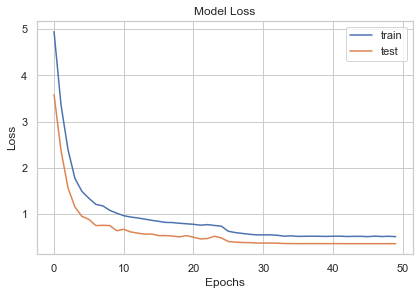

In [194]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

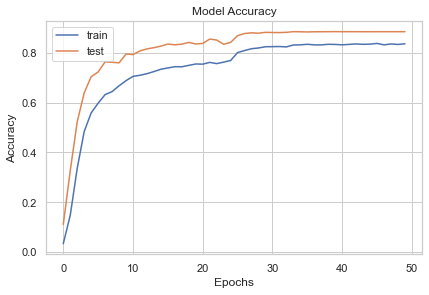

In [195]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

# 5 ) Visualizing Predictons on the Validation Set

In [196]:
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

333/333 [==============================] - 7s 19ms/step


In [197]:
pred

array([[1.4691788e-07, 1.0140388e-10, 1.6417403e-13, ..., 9.9215901e-01,
        1.9813979e-09, 7.8200605e-03],
       [5.5974317e-07, 7.1379923e-06, 8.0750362e-07, ..., 1.4759748e-10,
        4.9228875e-06, 1.9007114e-12],
       [2.2898117e-08, 5.4458524e-03, 1.4915636e-07, ..., 4.3017256e-08,
        4.4039465e-05, 1.8923909e-09],
       ...,
       [5.1703109e-06, 3.6094511e-12, 5.6002284e-07, ..., 1.6191636e-06,
        8.9771507e-05, 2.5247840e-07],
       [5.7790448e-13, 2.5548377e-09, 3.1160616e-10, ..., 5.2804660e-07,
        6.6514326e-14, 4.4875569e-06],
       [2.7946100e-12, 1.2098902e-10, 2.0948652e-02, ..., 5.9602914e-09,
        2.3098452e-09, 1.0709220e-07]], dtype=float32)

### 5.1) Get a list of correct and incorrect predictions

In [198]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(y_test[i]==pred_digits[i]):
        prop_class.append(i)
#     if(len(prop_class)==8):
#         break

i=0
for i in range(len(y_test)):
    if(y_test[i] != pred_digits[i]):
        mis_class.append(i)
#     if(len(mis_class) == 8):
#         break

In [199]:
print(f"Number of correct predictions: {len(prop_class)}")
print(f"Number of incorrect predictions: {len(mis_class)}")
print(f"Accuracy: {len(prop_class)/(len(prop_class) + len(mis_class) ) } ")

Number of correct predictions: 9402
Number of incorrect predictions: 1238
Accuracy: 0.8836466165413533 


### 5.2) Visualizing two smaples of correct and incorrect predictions

#### Correct

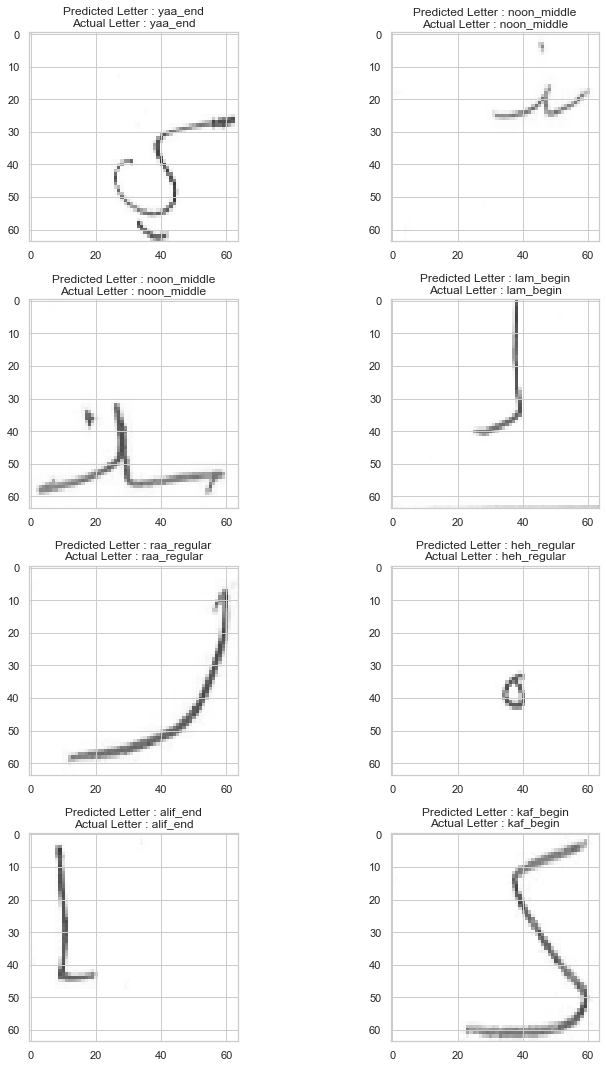

In [216]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Letter : " + str(dictionary_of_labels[pred_digits[prop_class[count]]])+
                          "\n" + "Actual Letter : " + str( dictionary_of_labels[y_test[prop_class[count]]]))

        plt.tight_layout()
        count+=1

#### Incorrect

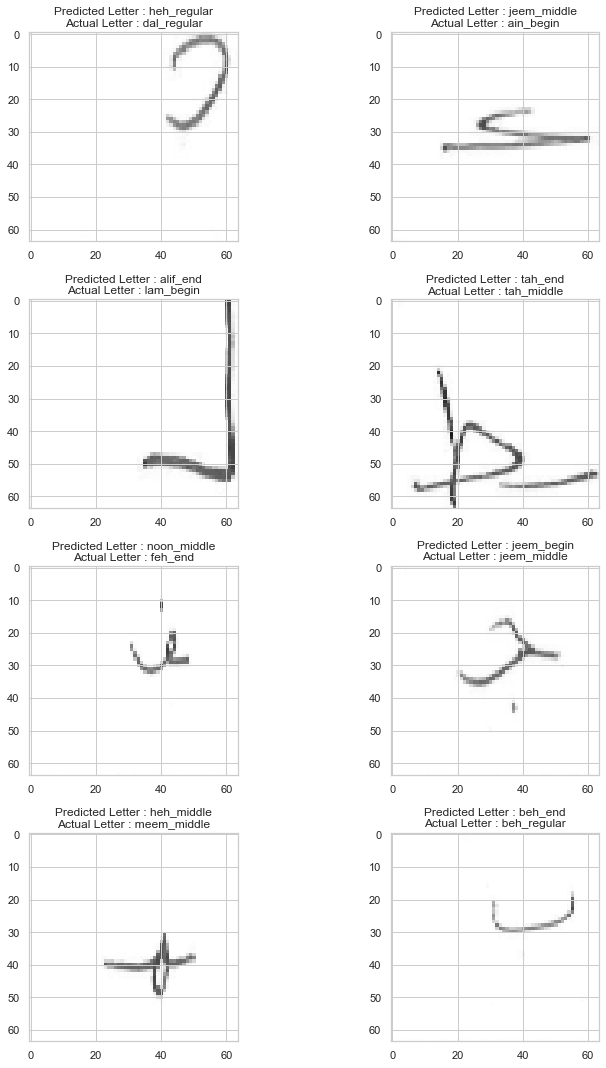

In [218]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Letter : " + str( dictionary_of_labels[pred_digits[mis_class[count]]])+
                          "\n" + "Actual Letter : " + str( dictionary_of_labels[y_test[mis_class[count]]]))

        plt.tight_layout()
        count+=1

# 6) Perediction of Test Images

### 6.1) Get the test images

In [202]:
DIR_Test = 'Final_Arabic_Alpha_dataset/test'
X_test = []
image_names = []

In [203]:
def make_test_data():
        for image_name in tqdm(os.listdir(DIR_Test)): 
            image_path = os.path.join(DIR_Test, image_name)
            image_names.append(image_name)
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)
            if img is None:
                print('Wrong path:', img)
            else:
                img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
                X_test.append(np.array(img))

In [204]:
make_test_data()

100%|█████████████████████████████████████| 10640/10640 [00:03<00:00, 2684.43it/s]


In [205]:
X_test=np.array(X_test)

### 6.2) Make predictions of test images

In [206]:
pred_test=model.predict(X_test)

333/333 [==============================] - 7s 20ms/step


In [207]:
pred_digits_test=np.argmax(pred_test,axis=1)

### 6.3) Visualisations of some random predicted images

100%|███████████████████████████████████████████████| 8/8 [00:04<00:00,  1.88it/s]


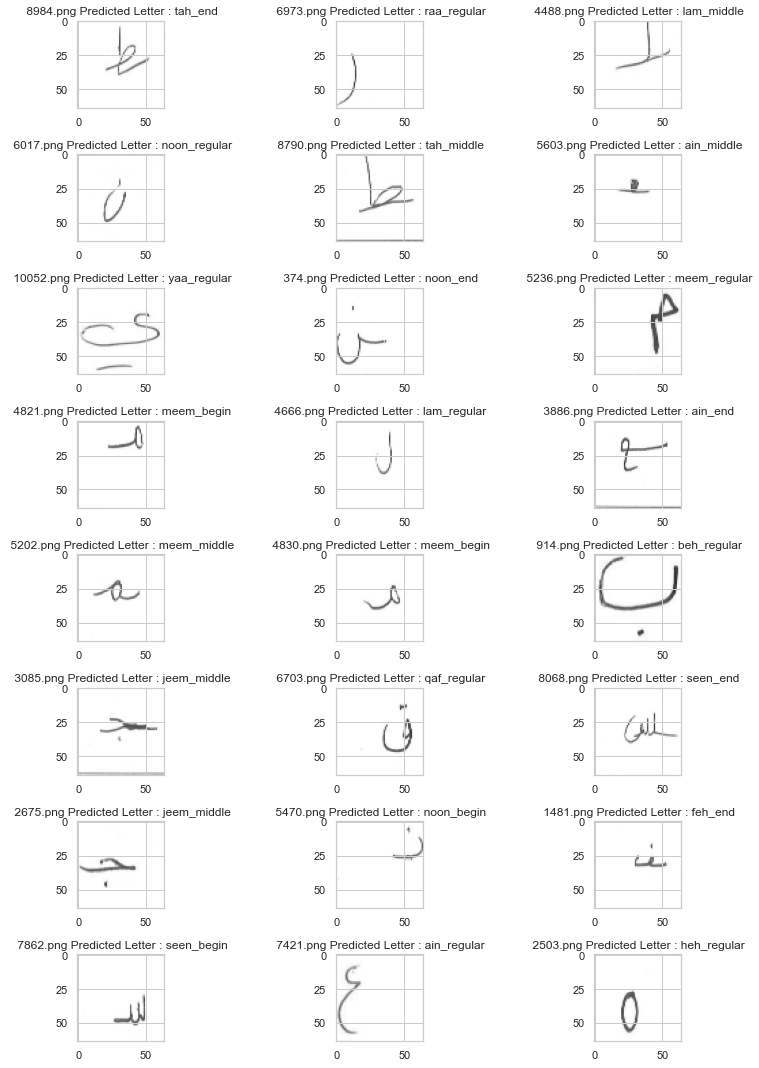

In [219]:
fig,ax=plt.subplots(8,3)
fig.set_size_inches(15,15)
for i in tqdm(range (8)):
    for j in range (3):
        image_number=rn.randint(0,len(X_test))
        ax[i,j].imshow(X_test[image_number])
        ax[i,j].set_title(f" {image_names[image_number]} Predicted Letter : " +
                          str(dictionary_of_labels[pred_digits_test[image_number]]))
        plt.tight_layout()

### 6.3) exporting the predicted

In [209]:
predictions = pred_digits_test
predictions_label = [dictionary_of_labels[i] for i in pred_digits_test]
image_numbers = [int(s[:-4]) for s in image_names]

In [220]:
df = pd.DataFrame({'ID': image_numbers, 'Label': predictions})

In [221]:
df

,ID,Label
0,3975,30
1,8820,57
2,9280,58
3,348,1
4,1804,18
...,...,...
10635,9299,6
10636,351,1
10637,437,1
10638,8839,58


In [222]:
df = df.sort_values(by='ID')

In [223]:
df

,ID,Label
10499,0,29
10113,1,29
9464,2,29
9804,3,29
8096,4,29
...,...,...
4601,10635,11
5289,10636,9
4758,10637,9
6052,10638,9


In [224]:
df.to_csv('predictions4.csv', index=False)

In [225]:
df.head(213)

,ID,Label
10499,0,29
10113,1,29
9464,2,29
9804,3,29
8096,4,29
...,...,...
8388,208,0
8251,209,44
2408,210,0
2264,211,0
